**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
November 13, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 2: “Sequence Models”**
**Due**: Monday, November 27, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: Part-of-Speech Tagging with a Bidirectional LSTM**  (2+4+5=11 points)

In this task we will be building a sequence tagger that produces an output for every element in an input sequence, using `PyTorch` and `TorchText`, where `TorchText` consists of data processing utilities and popular datasets for natural language.


*   **input:** a sequence of text
*   **output:** part-of-speech (POS) tag for each token in the input text

We tackle this task using a multi-layer bi-directional LSTM (BiLSTM) to predict POS tags using the [Universal Dependencies](https://universaldependencies.org/) English Web Treebank (UDPOS) dataset. This dataset is contained in the `TorchText` library and we do not require an external file for it. The dataset in  `TorchText`  has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We only focus on the UD tags for this assignment.

In [ ]:
%pip install portalocker

In [ ]:
%pip install torchdata

In [ ]:
%pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import UDPOS

import numpy as np

import time
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for reproducibility
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.backends.cudnn.deterministic = True

### Subtask 1: Data Analysis
The very basic components of the torchtext library include `vocab`, `word vectors`, and `tokenizer`. Those are the basic data processing building blocks for the raw text string.
In this case, we use the tokenizer and the vocabulary. Use the `build_vocab_from_iterator` to create the vocabulary for the text field and add the `<unk>` and `<pad>` tokens to it. Use a minimal frequency of `2`.
Also create a vocabulary for the labels (tag field). However, since the tags are predefined elements, you will not need an `<unk>` token.
 This dataset actually has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We train our model on the UD tags, which is the second element on the list of outputs (example below).


In [ ]:
train_iter = iter(UDPOS(split="train"))
print(next(train_iter))

[['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']]


In [ ]:
print(f"Number of training examples: {len(list(UDPOS(split='train')))}")
print(f"Number of validation examples: {len(list(UDPOS(split='valid')))}")
print(f"Number of testing examples: {len(list(UDPOS(split='test')))}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


Note that the data is already tokenized!

In [ ]:
train_iter = UDPOS(split="train") # to get the training set

### your code (make sure pad has id of 0) ####

# A helper function to retrieve tokens from the training set
def yield_tokens(train_iter, token_type):
    for line in train_iter:
        if token_type == 'text':
            yield line[0]
        elif token_type == 'tag':
            yield line[1]


# Generate the vocabularies for the text part
vocab = build_vocab_from_iterator(iterator=yield_tokens(train_iter, token_type='text'), min_freq=2, specials=["<pad>", "<unk>"])

# Set the default index to the index of "<unk>"
vocab.set_default_index(vocab["<unk>"])

# Generate the vocabularies for the tag part
ud_vocab = build_vocab_from_iterator(iterator=yield_tokens(train_iter, token_type='tag'), min_freq=2, specials=["<pad>"])

### your code ####


Prepare a text processing pipeline that takes raw input and labels and converts them to ids.

In [ ]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: ud_vocab(x)

In [ ]:
print(text_pipeline(['the', 'preacher', 'at', 'mosque', "<pad>","pppp"])) #should output [3, 9271, 35, 9097, 0, 1]
print(label_pipeline(['DET', 'ADJ', 'NOUN', 'PUNCT'])) # should output [6, 8, 1, 2]

[3, 9271, 35, 9097, 0, 1]
[6, 8, 1, 2]


In [ ]:
print(f"Unique tokens in input vocabulary: {len(vocab)}")
print(f"Unique tokens in UD vocabulary: {len(ud_vocab)}")

Unique tokens in input vocabulary: 9875
Unique tokens in UD vocabulary: 18


Write a custom function for the dataloader that applies the text and label pipeline and pads the sequences to have equal lengths.

In [ ]:
from functools import partial

def collate_batch(batch, pad_token_ix, pad_token_ix_ud):
    ### your code ###

    x_padded = [] #padded input

    y_padded = [] #padded predictions

    for text, ud_tag, ptb_tag in list(batch):

        # Storing the IDs of vocabularies in a tensor
        processed_text = torch.tensor(vocab(text), dtype=torch.int64)
        processed_ud_tag = torch.tensor(ud_vocab(ud_tag), dtype=torch.int64)

        # Append the tensors for the corresponding padding list
        x_padded.append(processed_text)
        y_padded.append(processed_ud_tag)


    # Pad each list element with 0, i.e. <pad>
    x_padded = nn.utils.rnn.pad_sequence(x_padded, batch_first=True, padding_value=0)
    y_padded = nn.utils.rnn.pad_sequence(y_padded, batch_first=True, padding_value=0)


    ### your code ###

    return x_padded.to(device), y_padded.to(device)

collate_fn = partial(collate_batch, pad_token_ix=vocab['<pad>'], pad_token_ix_ud=ud_vocab['<pad>'])


train_dataloader = DataLoader(
    UDPOS(split="train"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    UDPOS(split="valid"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    UDPOS(split="test"), batch_size=128, shuffle=True, collate_fn=collate_fn
)

In [ ]:
for idx, (label, text) in enumerate(train_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break


torch.Size([128, 57])
torch.Size([128, 57])
tensor([1832,   13,   17,  488, 2837,    3, 3074,    1, 5532,  512,   13,   23,
          56,  143,    5,  170,  154,  273,   39,  157,  971,   44, 2212,  648,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], device='cuda:0')
tensor([14,  4,  9, 12,  3,  6,  1,  1, 10, 17,  4,  3, 10, 13,  5, 13,  1, 10,
        14,  9,  3,  5,  7,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], device='cuda:0')


Let's take a closer look at the data and the distribution of tags.
Implement `tag_percentage`:

*   Use the `collection.counter` to count the unique instances of each tag.

*    Compute the percentage of each tag in the entire set, by using the counted frequencies.



In [ ]:
from collections import Counter

def tag_percentage(training_iterator):
    counter = Counter()
    #### your code to count the number of tags

    training_iterator_list = list(training_iterator)

    for text, ud_tag, ptb_tag in training_iterator_list:
        counter.update(ud_tag)

    ###
    ### compute the tag percentages based on the counter object

    tag_p = [(tag, counter[tag], (counter[tag] / sum(counter.values())) * 100.0) for tag in counter] #precentages
    ###
    return tag_p

In [ ]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UDPOS(split='train')):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

PROPN		12946		632.7%
PUNCT		23679		1157.3%
ADJ		12477		609.8%
NOUN		34781		1699.9%
VERB		23081		1128.1%
DET		16285		795.9%
ADP		17638		862.1%
AUX		12343		603.3%
PRON		18577		907.9%
PART		5567		272.1%
SCONJ		3843		187.8%
NUM		3999		195.4%
ADV		10548		515.5%
CCONJ		6707		327.8%
X		847		41.4%
INTJ		688		33.6%
SYM		599		29.3%


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
- The percentage has been miscalculated and is not presented in descending order (-0.5 point)
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: The Model

We start by creating a simple model and then make it more complex in later subtasks. The class `BiLSTMTagger` must subclass the `nn.Module` class of `PyTorch`. Fill the blank in the class by following the notes described below.
1.   The input is a sequence of tokens, $X = \{x_1, x_2,...,x_T\}$.
2.   Each token passes through  an embeddings layer, $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$. Use `nn.Embedding` for the embedding layer and make sure to pass in the index of the pad token.
3. Embedding is processed by forward and backward LSTMs from left to right and right to left.  The first input to the forward LSTM is $x_1$ and the first input to the backward LSTM is $x_T$. The hidden state of LSTMs is dependent on
the hidden, $h$, and cell, $c$, states from the previous time-steps:
$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
4. The hidden, $h$, and cell, $c$ of each layer is passed to the next layer, where the $h_0$ and $c_0$, for each direction and layer, are initialized to a tensor full of zeros. Use `nn.LSTM` for LSTM cells. How can you make it bidirectional?
5. Final hidden state is the concatenation of forward and backward hidden states from the final layer of the LSTM, $H = \{h_1, h_2, ... h_T\}$, where $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$. Use `nn.Linear` here.
6. The last layer is linear layer $f$, which is used to make the prediction of which tag applies to this token, $\hat{y}_t = f(h_t)$.
7. Define a `nn.Dropout` layer to apply to the embeddings and the outputs of the final layer of the LSTM.

In [ ]:
class BiLSTMTagger(nn.Module):
    def __init__(self, hyperparameters):
      '''
      hyperparameters: is a dictionary containing:
                 input_dim: dimension of the input
                 embedding_dim: dimension of the embedding layer
                 lstm_hidden_dim:: dimension of the hidden state of lstms
                 output_dim: dimension of the output hidden layer
                 n_layers: number of layers to stack
                 bidirectional: is the lstm bi-directional
                 dropout: probability for the drop out layer
                 pad_idx: id of the pad token
      '''
      super().__init__()
       #### your code ####
      #embedding layer
      self.embedding = nn.Embedding(hyperparameters['input_dim'], hyperparameters['embedding_dim'], padding_idx=hyperparameters['pad_idx'])
      #bi-lstm, apply dropout if the number of layers is more than 1
      self.lstm = nn.LSTM(hyperparameters['embedding_dim'], hyperparameters['lstm_hidden_dim'], num_layers=hyperparameters['n_layers'], bidirectional=hyperparameters['bidirectional'], dropout=hyperparameters['dropout'] if hyperparameters['n_layers'] > 1 else 0)
      self.fc = nn.Linear(hyperparameters['lstm_hidden_dim'] * 2 if hyperparameters['bidirectional'] else hyperparameters['lstm_hidden_dim'], hyperparameters['output_dim'])
      self.dropout = nn.Dropout(hyperparameters['dropout'])
      #### your code ####
    def forward(self, text, debug=False): #(B,S)
      '''
      S: sentence len
      B: batch size
      E: embedding size
      H: hidden size
      O:output size
      L: number of layers
      '''
      #### your code ####
      #pass text through embedding layer and a drop out layer
      embd = self.dropout(self.embedding(text))


      #pass embeddings into bi-LSTM
      outputs, (hidden, cell) = self.lstm(embd)

      #compute prediction
      predictions = self.fc(self.dropout(outputs))
      #### your code ####

      if debug==True:
        print("Input shape:",text.shape)
        print("Embedding shape:",embd.shape)
        print("LSTM output shape:",outputs.shape)
        print("LSTM hidden shape:",hidden.shape)
        print("LSTM cell shape:",cell.shape)
        print("Output shape:",predictions.shape)

      return predictions

Response in plain text:
1. Based on the notation defined in the forward function. What is the dimension of `outputs`, `hidden`, and `cell`?

In [ ]:
hyper_parameters={
  'input_dim':  len(vocab),
  'embedding_dim': 100,
  'lstm_hidden_dim': 128,
  'output_dim':len(ud_vocab),
  'n_layers': 2 ,
  'bidirectional':True,
  'dropout': 0.25,
  'pad_idx': vocab['<pad>']
}
model = BiLSTMTagger(hyper_parameters)

In [ ]:
input=torch.tensor([[3, 9271, 35, 9097, 0, 1],
                    [3, 9271, 35, 9097, 0, 1]])
model(input,debug=True).shape

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([4, 6, 128])
LSTM cell shape: torch.Size([4, 6, 128])
Output shape: torch.Size([2, 6, 18])


torch.Size([2, 6, 18])

Weights of the network are initialized randomly, so let's make a more systematic initialization to help us with the optimization. For example,  Xavier Initialization creates weights such that the variance of the activations is the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. However, it does not apply to bias terms.

Create a function that uses Xavier Initialization to initialize the weights of the network, for biases use a normal distribution with a mean of 0 and a standard deviation of 0.1.

In [ ]:
def init_weights(m):

  ### you code ###
  for name, param in m.named_parameters():
    nn.init.normal_(param.data, mean=0, std=0.1)
  ### your code ###
model.apply(init_weights)
model.to(device)

BiLSTMTagger(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Let's count the number of trainable parameters in our model.

In [ ]:
def count_parameters(model):
  ### your code ###
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  ### your code ###

print("number of trainable parameters:",count_parameters(model))

number of trainable parameters: 1622910


####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
- No solution for 1. question in given notations (-0.5)
- correct solution for output, hidden cell shapes
- Model implementation and forward function correct
- No distinction between bias vs weights made(-0.5)
- correct num parameters
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Training

We start by defining a loss function and an optimizer.


*   **optimizer:** We use Adam with the learning rate=0.0001.
*   **loss:** We use cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens to create batches of the same size. However, we do not want to calculate loss on those tokens, so make sure you define your loss function in such a way that ignores the `<pad>` tokens.




In [ ]:
### your code ###
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss(ignore_index=ud_vocab['<pad>'])
### your code ###

Watching the loss go down as you train a model is a good indication of the correct training procedure, but does not tell us how well we are doing on a given task.
To this end, we also implement a categorical accuracy measure to keep track of how well our model is doing on a given task.
Same as before: we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.
Implement the function `categorical_acc` to compare the prediction of non-pad tokens with labels count the correct ones and calculate the accuracy over a single batch.

In [ ]:
def categorical_acc(preds, gt, pad_idx):
    """
    Returns categorical accuracy per batch
    """
    ### your code ####
    # get the index of the max probability
    max_preds = preds.argmax(dim = 1, keepdim = True)
    # categorical accuracy
    non_pad_elements = (gt != pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(gt[non_pad_elements])
    temp =  correct.sum() / torch.FloatTensor([gt[non_pad_elements].shape[0]])

    return temp
     ### your code ####

In [ ]:
dummpy_input=torch.tensor([
    [0.9,0,0,0],
    [0.1,0.9,0,0],
    [0.1,0,0,0.9],
    [0.9,0.1,0,0],
    [0.1,0.8,0,0]

])
categorical_acc(dummpy_input, torch.tensor([0,2,3,0,1]), 0)

Define the `train` model that performs one epoch of training. You can refer to the Tutorial 2 of the course to get a sample workflow. The only difference to the tutorial is that we keep track of the batch-wise accuracy as well as the loss.

In [ ]:
def train(model, dataloader, optimizer, loss_function, pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    epoch_start_time = time.time()

    for length_dataloader,(text,tags) in enumerate(dataloader):
        #### your code ####


        #### your code ####
    end_time= time.time() - epoch_start_time
    return epoch_loss / length_dataloader, epoch_acc / length_dataloader,end_time

It is not enough to only look at the training loss and accuracy, since with more training, we can always do better on the training set, but lose the generalizability to unseen data, a phenomenon known as **overfitting**. Therefore, it is important to check the loss and accuracy on the validation set after each epoch and stop before  overfitting occurs. Moreover, we can use the validation metric as an indication of which checkpoint of our model is the best.

Define an `evaluate` function that runs once through the validation set and computes loss and accuracy. **Note:** You should not be updating gradients here and your model should be in evaluation mode.

In [ ]:
def evaluate(model, dataloader, loss_function, pad_idx):

    val_loss = 0
    val_acc = 0

    ### your code ###

     ### your code ###

    return val_loss / length_dataloader, val_acc / length_dataloader

Let's use the functions defined so far and train our model for `30` epochs. We suggest using GPU for this task, as it is quite slow on the CPU. Run the training loop for the given number of epochs and calculate the validation metric at the end of each epoch. Based on the validation loss, save the best checkpoint of the model.

In [ ]:
epochs = 30

best_valid_loss = float('inf')

for epoch in range(epochs):
    ### your code ###
    train_loss, train_acc, epoch_time =
    valid_loss, valid_acc =


    ### your code ###
    elapsed_mins = int(epoch_time / 60)
    elapsed_secs = int(epoch_time - (elapsed_mins * 60))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')

Question:

1. Does overfitting occur? If so, after which epochs?

2. How do you detect overfitting?


**Answer:**
```
Write your answer here.
```

Let's see how well our model is doing on the test set. Load the best checkpoint and calculate the accuracy.

In [ ]:
#### you code ####

#### you code ####
test_acc

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
- The learning rate is set to 0.001 instead of 0.0001 during initialization.
- function train model is missing: zero_grad(), .step() .backward() (-1 point)
- loss function is not called (-0.25 point)
- loss and accuracy are missing (-0.25 point)
- model.eval is not used (-0.25 point)
- the rest of the function is not completed (-0.5 point)
- the training and validation are not called (-0.25 point)
- checkpoint is not saved (-0.25 point)
- answer is missing for question 1 (-0.25 point)
- answer is missing for question 2 (-0.25 point)
- accuracy is not calculated (-0.25 point)
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Inference

Let's use the model we trained to tag some actual sentences. We have the preprocessing pipeline ready from Subtask 1, now we need to map the predictions back to label texts for each token.

Implement the `tag_sequence` function that takes a model and a sentence as input and generates POS tags. Keep in mind that you need to divide the sentence into tokens first. For this purpose, we just split each sentence on whitespaces.

In [ ]:
def tag_sentence(model, sentence):
    ### your code ###


    predictions = # make predictions on th esentence


    predicted_tags = # get the tags
    ### your code ###
    return predicted_tags

In [ ]:
text=" ".join(list(UDPOS(split='test'))[0][0])
label= list(UDPOS(split='test'))[0][1]
predicted_tag=tag_sentence(model,text)
print("Text: ",text)
print("Predicted Tags: ",predicted_tag)
print("True Tags: ",label)

####${\color{red}{Comments\ 1.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
- prediction doesn't exist (-0.5)

total 11 − 0.5 - 1.0 - 3.5 - 0.5 = 5.5 points
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Theoretical Questions** (0.5+1.5+1+3=6 points)

### Subtask 1:
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

**Answer:**


```
a) Increasing beam width generally increases runtime and memory usage.
b) Increasing beam width can improve the quality of results by exploring a larger search space but may also lead to more redundancy.
```



####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
- a is correct
- b is correct
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2:
Except for beam search, there are other ways to create a more coherent output for generation tasks, one of which is adding a temperature to the softmax over the vocabulary. Temperature is a hyperparameter that is applied to the input of a softmax to affect the final probabilities. All values in the input are divided by the temperature before going through the softmax. What do you think will happen in these cases:

1. A low temperature - below 1
2. A high temperature - above 1
3. Really small temperature - temperature $→$ 0

**Answer:**
```
Low temperature (below 1): This will make the probability distribution more peaked. It will emphasize high-probability words and suppress the influence of low-probability words. The generated output is likely to be more focused and deterministic.

High temperature (above 1): This will make the probability distribution flatter. It will assign more equal probabilities to a broader range of words, including both high and low-probability words. The generated output is likely to be more diverse but might lack precision.

Really small temperature (approaching 0): As the temperature approaches zero, the softmax operation amplifies differences between the input values. This results in a distribution that tends to have a single dominant probability. The output becomes highly deterministic, with a strong focus on the word with the highest probability.



```

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
- 1 is correct
- 2 is correct
- 3 is correct but could've been used better terminology ,for temperature zero case, to describe highly deterministic ---> greedy
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3:
Explain what the “bottleneck” of an encoder-decoder RNN is and how attention provides a way to get around this bottleneck.

**Answer:**
```
The "bottleneck" in an encoder-decoder RNN refers to the fixed-size internal representation (context vector) that the encoder produces for the entire input sequence. This fixed-size representation may struggle to capture all relevant information, especially in long sequences. Attention mechanisms address this bottleneck by allowing the decoder to dynamically focus on different parts of the input sequence when generating each element of the output sequence. This way, attention provides a flexible way to access and utilize the entire input sequence during the decoding process, improving the model's ability to handle long-range dependencies and capture relevant information.
```

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
- the solution correctly describes the bottleneck in RNN and explains advatange of attention for long sequences. It is correct thus.
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4:
As mentioned, there are various way to remedy the repetitiveness and incoherence of generation outputs. One of the widely used methods is Nucleus sampling described the paper "[ The Curious Case of Neural Text DeGeneration](https://arxiv.org/pdf/1904.09751.pdf)". Read the model section and introduction of the paper and use it as reference to answer the following questions:

1. Describe top-k sampling in your own words, no need for mathematical notation.
2. Describe Nucleus sampling in your own words, there is not need for mathematical notation.
3.  Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?


**Answer:**
```
**Top-k Sampling:**
In top-k sampling, during the generation process, instead of sampling from the entire vocabulary, only the top-k most likely words are considered. The model's probabilities are calculated for all words, and then the sampling is confined to the k words with the highest probabilities. This helps in limiting the randomness of the generated text and provides a balance between controlled output and diversity.

**Nucleus Sampling:**
Nucleus sampling is an extension of top-k sampling. Rather than fixing the number of options (k), nucleus sampling involves sampling from the smallest set of words whose cumulative probability exceeds a certain threshold (nucleus probability). This dynamic approach adapts to the changing distribution of word probabilities, allowing for more flexibility in controlling the diversity of generated text.

**Beam Search Limitations:**
Beam search is a strategy that explores multiple possible sequences during generation and selects the one with the highest overall probability. However, beam search tends to produce outputs that are too focused and may lack diversity. It often converges to a narrow set of possibilities, leading to repetitive and less human-like text.

**Advantages of Top-k and Nucleus Sampling:**
Top-k and nucleus sampling allow for more diverse and contextually relevant outputs. By not strictly adhering to a fixed beam width, these methods can capture a wider range of possibilities and avoid the narrow focus problem of beam search. They provide a balance between exploring various options and maintaining coherence in the generated text, making them more suitable for human-like text generation.
```

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
- 1 is correct
- 2 is correct
- 3 is incorrect (-1.0), it seems correct in very simple terminology but lacks the explanation with tail distribution. It also fails to address 2nd part of question.


total points: 0.5 + 1.5 + 1 + (3-1) = 5
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Scaled Dot-Product Attention** (4+1=5 points)
In class, you learned about attention and Transformers as described in the 2017 paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762).
The base of the attention module is a scaled dot product with Queries, Keys, and Values.
In this task, you will implement a simplified version of scaled dot-product attention and inspired by the translation task, aim to replicate word alignment between English and French.
You will not be training the embedding from scratch, we provide you with pre-trained embedding for both languages.
However, you need to know the details of scaled dot product attention, which mainly consists of two matrix multiplications and a softmax scaling.
Refer to Figure 2 of the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

The inputs of the attention module are Queries, Keys, and Values. Mathematically, attention is defined as follows:

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$


*   $Q$, $K$, and $V$ are the Queries, Keys, and Values matrices.
* $d_k$ is the dimension of the Keys (in practice dimensions of all matrices are the same).
*   $QK^{\top}$ is a measure of the similarity between the Queries and the Keys
* softmax transforms the similarity into weights.
* Weights multiplied by the Values are the output of the attention, defining how much importance should be given to each token of the input.

In the case of self-attention, both Queries and Keys come from the encoder, however, for cross attention between encoder and decoder, decoder states are used as the queries while encoder states are the Keys and Values.
In our case, we need the cross attention between one language to another to find the correct alignment.


In [ ]:
%pip install matplotlib

     ---------------------------------------- 0.0/158.4 kB ? eta -:--:--
     -------------------------------------- 158.4/158.4 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   --- ------------------------------------ 0.7/7.6 MB 14.8 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/7.6 MB 14.0 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/7.6 MB 13.5 MB/s eta 0:00:01
   ------------- -------------------------- 2.5/7.6 MB 14.5 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.6 MB 14.1 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.6 MB 13.9 MB/s eta 0:00:01
   ---------------------- ----------------- 4.3/7.6 MB 13.8 MB/s eta 0:00:01
   ------------------------- -------------- 4.9/7.6 MB 13.6 MB/s eta 0:00:01
   ---------------------------- ----------- 5.5/7.6 MB 13.5 MB/s eta 0:00:01
   ------------------------------- -------- 6.1/7.6 MB 13.0 MB/s eta 0:00:01
   -----

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#load the dictionaries (dictionary of words to ids)
with open("./word2int_en.pkl", "rb") as f:
    en_dict = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
    fr_dict = pickle.load(f)

# load word embeddings (dictionary of token ids to embeddings)
en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]


### Subtask 1: Attention Weights
Fill the blanks in `tokenize` to tokenize a sentence and convert it to ids and `embed` function to create an embedding of a sentence.

In [ ]:
def tokenize(sentence, token_mapping):
    # token_mapping contains 10000 words to their ids
    # we stick to simple blank space tokenization
    tokenized = []
    for word in sentence.lower().split(" "):
        ### your code ###
        # if the word is in token mapping, then take its id from token_mapping
        if word in token_mapping:
            tokenized.append(token_mapping[word])
        else:
            # if not in the token mapping, use -1 as id (suggested by Almasian, Shideh)
            # print("NOT FOUND")
            # print(f"NOT FOUND {word}")
            tokenized.append(-1)
        ### your code ###
    return tokenized


def embed(tokens, embeddings):
    """ get the embedding for the tokens in a sentence stacked in a simple matrix (sequence length, embedding size)
        tokens: tokenized sentence
        embeddings: dictionary of token to embeddings.
    """
    embed_size = embeddings.shape[1]
    #### your code ####
    seq_length = len(tokens)
    output = np.zeros((seq_length, embed_size)) # initially everything is 0
    for i, token in enumerate(tokens):
        if 0 <= token < embeddings.shape[0]: # check if we have an embedding for the given token
            output[i] = embeddings[token]
        else: # if we do not have an embedding for the token
            output[i] = np.zeros(embed_size) # np.random.rand(embed_size) could be used to add a random embedding
    #### your code ####
    return output

In [ ]:
sentence_en = "there were clouds in my coffeeeeee."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)
print("Tokenized english:",tokenized_en)
print("embedding english:",embedded_en.shape)

sentence_fr = "il y avait des nuages ​​dans mon ccafé."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
print("Tokenized french:",tokenized_fr)
print("embedding french:",embedded_fr.shape)

Tokenized english: [59, 40, 9355, 6, 158, -1]
embedding english: (6, 300)
Tokenized french: [21, 73, 192, 16, 8652, -1, 558, -1]
embedding french: (8, 300)



Implement the `softmax` function with `Numpy`.


In [ ]:
def softmax(x, axis=0):
    """
    x: input matrix
    axis: defines which axis to compute the softmax over 0 for rows and 1 for columns
        axis=0 calculates softmax across rows which means each column sums to 1
        axis=1 calculates softmax across columns which means each row sums to 1
    """

    #### your code ####
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True)) # use shifting to avoid overflow
    softmax_x = exp_x / np.sum(exp_x, axis=axis, keepdims=True)
    #### your code ####

    return softmax_x

In [ ]:
w=softmax(np.array([[1,3,4,1], [24,3,2,3]]),axis=0)
w.sum(axis=0)[0]

1.0

Use the `softmax` function to calculate the weights.
$$ \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
Assume the queries and keys are 2D matrices.

In [ ]:
def calc_weights(queries, keys):
    """
    queries: queries matrix
    keys: keys matrix
    """
    #### your code ####
    d_k = keys.shape[1]
    weights = softmax(np.dot(queries, keys.T) / np.sqrt(d_k), axis=1)
    #### your code ####

    return weights

In [ ]:
weights=calc_weights(np.array([[1,3],[1,3]]),np.array([[0,3],[2,3]]))
print(weights)
weights.sum(axis=1)[0]

[[0.19557032 0.80442968]
 [0.19557032 0.80442968]]


1.0

Use the `calcu_weights` to compute the attention matrix between two sentences from English and French and visualize the weights to check for alignments.

The top allignment is between the words 'nuages' and 'clouds' with a score of 0.09370453641488403
The second top allignment is between the words 'café' and 'coffee' with a score of 0.0932135859530074


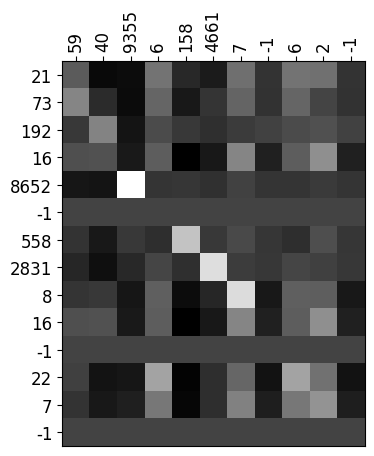

In [ ]:
sentence_en = "there were clouds in my coffee and unicorns in the sky."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "il y avait des nuages ​​dans mon café et des licornes dans le ciel."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)

alignment = calc_weights(embedded_fr, embedded_en)
# visualize weights
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(alignment,cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=12);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=12);


### your code to compute the top-2 ###
top1_score = -1
top2_score = -2
top1_coordinates = [None, None]
top2_coordinates = [None, None]
for i in range(alignment.shape[0]):
    for j in range(alignment.shape[1]):
        if alignment[i][j] >= top1_score:
            top2_score = top1_score
            top2_coordinates = top1_coordinates
            top1_score = alignment[i][j]
            top1_coordinates = [i, j]
        elif alignment[i][j] > top2_score:
            top2_score = alignment[i][j]
            top2_coordinates = [i, j]


top1_words = [sentence_fr.split(" ")[top1_coordinates[0]], sentence_en.split(" ")[top1_coordinates[1]]]
top2_words = [sentence_fr.split(" ")[top2_coordinates[0]], sentence_en.split(" ")[top2_coordinates[1]]]
print(f"The top allignment is between the words '{top1_words[0]}' and '{top1_words[1]}' with a score of {top1_score}")
print(f"The second top allignment is between the words '{top2_words[0]}' and '{top2_words[1]}' with a score of {top2_score}")
### your code ###

1. What are the top 2 alignments shown in the figure?
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?

**Answer:**

```
1. What are the top 2 alignments shown in the figure?
    The top alignment shown in the figure is between the words 'nuages' and 'clouds' with an alignment score of 0.09370453641488403

    The second top aligment shown in the figure is between the words 'café' and 'coffee' with an alignment score of 0.0932135859530074
    
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?
    I think that is due to the fact that `ciel` and `dans` and `licornes` do not have predefined embeddings and they get the same embedding (zeros) because of not having a predefined emebedding. This makes them unrelated to other words.
```

#### ${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
✅ Point distribution ✅ 4/4
- Tokenization outputs are correct
- embedding shapes are correct
- Weights are correct and softmax sum is 1.0. (0.5 + 0.5 = 1.0). 

The provided solution uses a try-except block to handle unknown words, assigning -1 as the token ID.
Yours explicitly checks if the word is in the token mapping before assigning its ID.
Both solutions initialize the embedding matrix with zeros.
Your solution includes a check to ensure that the token ID is within the valid range for embeddings. (0.5 + 0.5 = 1.0)

For softmax implementation, the solution is correct and provides the correct output, by modularizing the softmax calculation by using a separate function which may be considered more readable. (0.5 + 0.5 = 1.0)

Both solutions are correct in calculating the top-2 alignments. Your solution includes a visualization with numerical row and column labels. It would have been better to visualize it with words. Both Q-A answers are true. You focused on the absence of predefined embeddings, while the provided solution focuses on random embeddings not being sufficient for the attention module. (0.5 + 0.5 = 1.0)


```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Scaled Dot-product
Implement the scaled dot-product attention using the functions from above.



In [ ]:
def attention(queries, keys, values):
    """  scaled dot-product attention
    queries: query matrix
    keys: key matrix
    value: value matrix
    """

    #### your code ####
    attention = np.dot(calc_weights(queries, keys), values)
    #### your code ####
    return attention


attention_result = attention(embedded_fr, embedded_en, embedded_en)
print(attention_result.shape)
print(attention_result[0:2,:10])

(14, 300)
[[-0.0077802  -0.00345834 -0.01493142  0.05936939 -0.02286767 -0.00835552
   0.00079745 -0.03737862  0.0270674   0.05374082]
 [-0.00777829 -0.00336843 -0.01498988  0.05937157 -0.02285948 -0.00835695
   0.00085725 -0.03740797  0.02706951  0.05377672]]


####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
✅ Point distribution ✅ 1/1
Solution is correct and produce identical outputs with the provided solution. Attention operation has been applied appropriately, and attention mechanism is functioning as intended. (0.5 + 0.5 = 1.0)


Total task 3 points: 4 + 1 = 5
```



${\color{red}{⚠️Comments\ end⚠️}}$